#  Structural Graph Embeddings

In [1]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import torch.nn as nn
import numpy as np
import torch
from sklearn.metrics import mutual_info_score
from sklearn.decomposition import PCA
import requests
from sklearn.cluster import k_means
from tqdm.notebook import tqdm, trange
from torch.utils.data import Dataset
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import networkx as nx

### Facebook graph

In this assignment, we will evaluate node embedding methods on the facebook graph where nodes are pages and edges are links. Each node has a category: government, tv-show, company, politician.

In [2]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/musae_facebook_ego_802.gml'
open('musae_facebook_ego_802.gml', 'wb').write(requests.get(url).content)
G = nx.read_gml('musae_facebook_ego_802.gml')
G = nx.convert_node_labels_to_integers(G)
_labels = np.array(list(nx.get_node_attributes(G, 'value').values()))
unique = list(set(_labels))
labels = np.array([unique.index(l) for l in _labels])
len(G), labels

(3873, array([2, 2, 2, ..., 3, 3, 3]))

### Task 1. DeepWalk (0 points)

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Deepwalk is an approach for learning latent representations of nodes in a network. The motivation of DeepWalk is based on an observation that the frequency of nodes occurrence in the short random walks in social networks is similar to the frequency of words occurrence in sentences in natural languages.

<img src="https://raw.githubusercontent.com/netspractice/network-science/main/images/node_word_powerlaw.png" width=600>

The both follow a power-law distribution, therefore NLP word embedding models can help to represent nodes in networks. DeepWalk is based on SkipGram model that is trained to predict the context for a given word.

<img src='https://lena-voita.github.io/resources/lectures/word_emb/w2v/window_prob1-min.png' width=600>

(an image is taken from [NLP Course For You](https://lena-voita.github.io/nlp_course.html))

DeepWalk uses nodes instead of words and random walks on a network instead of sentences. Let a central word be a start node of a random walk, context words be nodes in a tail of a random walk.

Write a function `sample_random_walks` that takes a graph, number of walks per node and the length of walks, returns np.array of the shape (total number of walks) x (length).

In [4]:
def sample_random_walks(G, walks_per_node, length):
    ### BEGIN SOLUTION
    walks = []
    for node in tqdm(G.nodes):
        for _ in range(walks_per_node):
            walk = [node]
            current_node = node
            for _ in range(length - 1):
                next_node = np.random.choice(list(G.neighbors(current_node)))
                walk.append(next_node)
                current_node = next_node
            walks.append(walk)
    return np.array(walks)
    ### END SOLUTION

In [5]:
walks_per_node = 5
length = 5
rwalks = sample_random_walks(G, walks_per_node, length)
assert rwalks.shape == (len(G) * walks_per_node, length)
assert np.all(rwalks[:, 0][::5] == np.arange(len(G)))
A = nx.to_numpy_array(G)
assert np.all(A[rwalks[0, :-1], rwalks[0, 1:]] == 1)

  0%|          | 0/3873 [00:00<?, ?it/s]

In [6]:
rwalks

array([[   0,   37,    7,   30,  101],
       [   0,   10,   47,   13,  186],
       [   0,   28,   23,  124,   64],
       ...,
       [3872, 1495,  169,  410,  248],
       [3872, 1495, 3181,  409, 2148],
       [3872, 1980, 2121,  253,  303]])

Consider a graph $G=(V,E)$. Let the first node in each random walk be _start node_ and others be _context nodes_. DeepWalk uses two embedding layers:
* $v_i: \{0, 1\}^{|V|} \to \mathbb R^{d}$ embeds the one-hot encoded vector of the start node $i$ to latent space
* $u_j: \{0, 1\}^{|V|} \to \mathbb R^{d}$ embeds the one-hot encoded vector of the context node $j$ to latent space

The objective is to maximize the probability that $i$ and $j$ co-occur on a random walk over the network. Maximizing of the probability is equivalent to minimizing negative log-likelihood:

$$\mathcal L = - \frac{1}{|V|\times N} \sum_{i=1}^{|V|\times N} \sum_{j=1}^L \log P(j|i)$$

where $N$ is the number of walks per node, $L$ is the length of a random walk excluding start node. $P(j|i)$ can be modelled by softmax with dot product similarity score $\text{sim}(i, j) = u_i^\top v_j$ as follows:

$$\mathcal L = - \frac{1}{|V|\times N} \sum_{i=1}^{|V|\times N} \sum_{j=1}^L \log \frac{\exp(v_i^\top u_j)}{\sum_{k=1}^{|V|}\exp(u_k^\top v_i)}$$

However, calculating $\sum_{k=1}^{|V|}\exp(v_i^\top u_j)$ is computationally expensive in a large network. To overcome such an obstacle, we can approximate softmax by binary cross-entropy with _negative sampling_. Instead of calculating softmax, we draw some random (negative) context and minimize binary cross-entropy using sigmoid function:

$$\mathcal L^{\text{pos}}_{ij} = -\log P(j|i) = - \log \sigma(v_i^\top u_j) \\
\mathcal L^\text{neg}_{ij} = -\sum_{k=1}^K \log P(k|i) = -\sum_{k=1}^K \log (1 - \sigma(v_i^\top u_k)) \\ 
\mathcal L = \frac{1}{|V|\times N} \sum_{i=1}^{|V|\times N} \sum_{j=1}^L \left(\mathcal L^{\text{pos}}_{ij} + \mathcal L^\text{neg}_{ij}\right)$$

where $K$ is the number of negative nodes for each context node.

Let us create a dataset for computing a such loss function. Write a class `NodeContextDataset`. 

Function `__init__` takes random walks, the number of nodes in a graph and the number of negative nodes per each context node.

Function `__len__` returns the number of random walks.

Function `__getitem__` takes an index of random walk, sample a negative context and returns a tuple:

* start node, torch.int64
* positive context nodes, torch.tensor of the shape (number of context nodes)
* negative context nodes, torch.tensor of the shape (number of context nodes, number of negative nodes)

In [7]:
class NodeContextDataset(Dataset):
    def __init__(self, rwalks, n_nodes, n_neg):
        ### BEGIN SOLUTION
        self.n_nodes = n_nodes
        self.n_neg = n_neg
        self.start_nodes = torch.tensor(rwalks[:, 0]).long()
        self.pos_context = torch.tensor(rwalks[:, 1:]).long()
        self.len_context = rwalks.shape[1] - 1
        ### END SOLUTION

    def __len__(self):
        ### BEGIN SOLUTION
        return len(self.start_nodes)
        ### END SOLUTION

    def __getitem__(self, idx):
        ### BEGIN SOLUTION
        neg_context = torch.randint(
            high=self.n_nodes, 
            size=(self.len_context, self.n_neg)
        )
        return self.start_nodes[idx], self.pos_context[idx], neg_context
        ### END SOLUTION

In [8]:
dataset = NodeContextDataset(rwalks, len(G), n_neg=5)
assert len(dataset) == rwalks.shape[0]
start_node, pos_context, neg_context0 = dataset[0]
start_node, pos_context, neg_context1 = dataset[0]
assert start_node == 0
assert start_node.dtype == torch.int64
assert start_node.shape == ()
assert pos_context.shape == (4, )
assert neg_context0.shape == neg_context1.shape ==(4, 5)
assert not torch.all(neg_context0 == neg_context1)
dloader = DataLoader(dataset, batch_size=2)
for start_nodes, pos_context, neg_context in dloader:
    break
assert start_nodes.shape == (2,)
assert pos_context.shape == (2, 4)
assert neg_context.shape == (2, 4, 5)

Write a function `cross_entropy` that takes vectors $v$, positive $u$, negative $u$ and returns the binary cross-entropy loss before reduction $\frac{1}{|V|\times N} \sum_{i=1}^{|V|\times N} \sum_{j=1}^L$.

_Remark: to prevent $-\infty$ in log, add $\varepsilon=1^{-6}$ as follows `torch.log(x + 1e-6)`_

In [9]:
def cross_entropy(v, u_pos, u_neg):
    ### BEGIN SOLUTION
    score = (v[:, None, :] * u_pos).sum(dim=2)
    pos_loss = -torch.log(torch.sigmoid(score) + 1e-6)
    score = (v[:, None, None, :] * u_neg).sum(dim=3)
    neg_loss = -torch.log(1 - torch.sigmoid(score) + 1e-6).sum(dim=2)
    loss = pos_loss + neg_loss
    return loss
    ### END SOLUTION

In [10]:
np.random.seed(0)
start_node_emb = torch.randn(len(G), 16)
context_emb = torch.randn(len(G), 16)
v = start_node_emb[start_nodes]
u_pos = context_emb[pos_context]
u_neg = context_emb[neg_context]
loss = cross_entropy(v, u_pos, u_neg)
assert loss.shape == (2, 4)
lpos = -torch.log(torch.sigmoid(v[0] @ u_pos[0, 0]) + 1e-6)
lneg = -torch.log(1 - torch.sigmoid(torch.tensor([v[0] @ u_neg[0, 0, i] for i in range(5)])) + 1e-6).sum()
assert round((lpos + lneg).item(), 2) == round(loss[0, 0].item(), 2)

Here is SkipGram model with negative sampling. It takes start nodes and positive, negative context nodes, returns cross-entropy loss.

In [11]:
class SkipGramNegativeSampling(nn.Module):
    def __init__(self, n_nodes, dim):
        super().__init__()
        self.start_node_emb = nn.Embedding(n_nodes, dim)
        self.context_emb = nn.Embedding(n_nodes, dim)
    def forward(self, start_nodes, pos_context, neg_context):
        v = self.start_node_emb(start_nodes)
        u_pos = self.context_emb(pos_context)
        u_neg = self.context_emb(neg_context)
        return cross_entropy(v, u_pos, u_neg)

Let us train the model using Adam optimizer.

  0%|          | 0/50 [00:00<?, ?it/s]

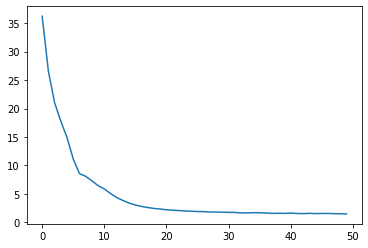

In [12]:
sgmodel = SkipGramNegativeSampling(n_nodes=len(G), dim=16)
epoch_loss = []
opt = Adam(sgmodel.parameters(), lr=0.1)
dloader = DataLoader(dataset, batch_size=len(G))
for epoch in trange(50):
    for start_nodes, pos_context, neg_context in dloader:
        loss = sgmodel(start_nodes, pos_context, neg_context).sum(dim=1).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
    epoch_loss.append(loss.item())
plt.plot(epoch_loss);

We evaluate the model by mutual information between ground truth labels and cluster indices.

In [13]:
with torch.no_grad():
    emb = sgmodel.start_node_emb(torch.arange(len(G)))
_, pred_labels, _ = k_means(emb, n_clusters=8)
mi = mutual_info_score(labels, pred_labels)
assert mi > 0.15

Let us plot the t-SNE visualization of node embeddings.

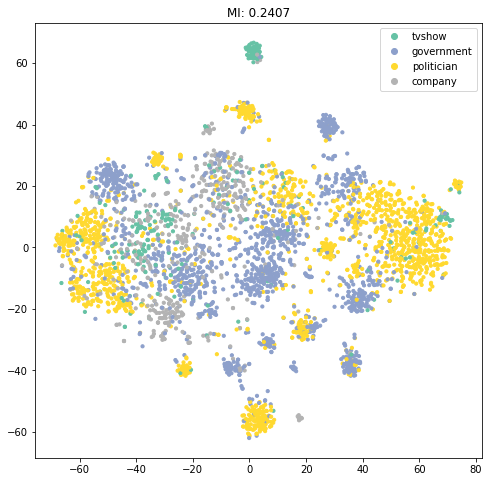

In [14]:
decomposition = TSNE(n_components=2)
xy_emb = decomposition.fit_transform(emb)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(xy_emb[:, 0], xy_emb[:, 1], c=labels, s=10, cmap=plt.cm.Set2)

plt.legend(handles=scatter.legend_elements()[0], labels=unique)
plt.title(f'MI: {mi:.4f}');

### Task 2. Node2Vec (3 points)

In this task, we will consider Node2Vec embedding algorithm. In Node2Vec, we learn a mapping of nodes to a low-dimensional space of features that maximizes the likelihood of preserving network neighborhoods of nodes. It is similar to DeepWalk, but uses *biased random walk procedure* which efficiently explores diverse neighborhoods. There are two parameters:

* Return parameter $p$ controls the likelihood of immediately revisiting a node in the walk. Setting it to a high value ensures that we are less likely to sample an already-visited node in the following two steps.

* In-out parameter $q$ allows the search to differentiate between “inward” and “outward” nodes. If $q > 1$, the random walk is biased towards nodes close to previous node. In contrast, if $q < 1$, the walk is more inclined to visit nodes which are further away from the previous node.

<img src='https://raw.githubusercontent.com/netspractice/network-science/main/images/biased_random_walk.png' width=300>

Consider that we just moved from the node $t$ to $v$ and now we want to decide on the next step so it evaluates the transition probabilities on edges ($v$, $x$) leading from $v$. Then the *unnormalized* probability is

$$\alpha = \begin{cases}
\frac{1}{p} &  \text{ if } d_{tx} = 0\\
1 & \text{ if } d_{tx} = 1\\
\frac{1}{q} & \text{ if } d_{tx} = 2\\
\end{cases}$$

where $d_{tx}$ is the shortest path distance between nodes $t$ and $x$. To compute the true probability, we need to normalize values so that the sum is 1.

Write a function `biased_random_walk` that takes a graph, node for which we start random walk, length of walk, parameters `p` and `q` and returns a list with random walks.

*Hint: do not use `nx.shortest_path` to calcule shortest paths, it is too expensive. Look at the image above — we can explicitly calculate probabilities for all neighbors of $v$ using neighborhood of $t$*.

In [15]:
import random
random.seed(7575)
def biased_random_walk(G, node, length, p, q):
    walk = []
    #the first node
    walk.append(node)
    neighbor = list(nx.neighbors(G, node))
    next_node = random.choice(list(nx.neighbors(G, node)))

    for i in range(length - 1):
      walk.append(next_node)
      next_neighbor = list(nx.neighbors(G, next_node))
      probabilities = []
      for n in next_neighbor:
        if n == node:
          probabilities.append(1/p)
        elif n in neighbor:
          probabilities.append(1)
        else:
          probabilities.append(1/q)
      probabilities = np.array(probabilities)
      probabilities = probabilities / np.sum(probabilities)
      node = next_node
      next_node = np.random.choice(list(nx.neighbors(G, next_node)), replace = True, p=probabilities)
      neighbor = next_neighbor
    return walk

In [16]:
rwalks = biased_random_walk(G, 0, 10, 0.1, 0.5)
assert len(rwalks) == 10
rwalks = biased_random_walk(G, node=0, length=4, p=0.001, q=1000)
assert rwalks[0] == rwalks[2]
assert rwalks[1] == rwalks[3]
rwalks = biased_random_walk(G, node=0, length=4, p=1000, q=0.001)
assert len(set(rwalks)) >= 3

Let us generate biased random walks.

In [17]:
def sample_biased_random_walks(G, walks_per_node, length, p, q):
    walks = []
    for node in tqdm(G.nodes, leave=False, desc='Sampling biased random walks'):
        for _ in range(walks_per_node):
            walk_from_node = biased_random_walk(G, node, length, p, q)
            walks.append(walk_from_node)
    return np.array(walks)

In [18]:
walks_per_node = 5
length = 5
rwalks = sample_biased_random_walks(G, walks_per_node, length, p=0.25, q=0.25)
rwalks

Sampling biased random walks:   0%|          | 0/3873 [00:00<?, ?it/s]

array([[   0,   32,    9,   74,  256],
       [   0,   35,    0,   32,  189],
       [   0,   36,  181,  185,   46],
       ...,
       [3872, 1980,  410,  119,  210],
       [3872, 1495, 2116,  206, 2105],
       [3872, 1980, 3872, 1980, 3178]])

Train the model.

  0%|          | 0/50 [00:00<?, ?it/s]

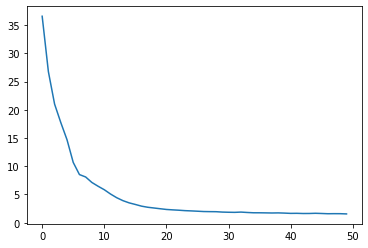

In [19]:
e_loss = []
dataset = NodeContextDataset(rwalks, len(G), n_neg=5)
dloader = DataLoader(dataset, batch_size=len(G))
sgmodel = SkipGramNegativeSampling(n_nodes=len(G), dim=16)
opt = Adam(sgmodel.parameters(), lr=0.1)
for e in trange(50):
    for start_nodes, pos_context, neg_context in dloader:
        loss = sgmodel(start_nodes, pos_context, neg_context).sum(dim=1).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
    e_loss.append(loss.item())
plt.plot(e_loss);

In [20]:
with torch.no_grad():
    emb = sgmodel.start_node_emb(torch.arange(len(G)))
_, pred_labels, _ = k_means(emb, n_clusters=8)
mi = mutual_info_score(labels, pred_labels)
assert mi > 0.15

Find the best $p$ and $q$. Write a function `grid_search_pq` that takes a graph, node labels and returns the best $p$ and $q$ by grid search in $\{0.01, 0.2, 1, 2, 8\}$. Sample biased random walks with 5 walks per node and the length 5. Evaluate the model by mutual information score between ground truth labels and k-means with 8 clusters. To pass time limits, calculate the best `p` and `q` and then rewrite the function as

```python
def grid_search_pq(graph):
    return best_p, best_q
    # your grid search implementation ...
```

In [21]:
def grid_search_pq(G, labels):
    # YOUR CODE HERE
    
    return 8, 1

In [22]:
best_p, best_q = grid_search_pq(G, labels)
rwalks = sample_biased_random_walks(G, 5, 5, best_p, best_q)
dataset = NodeContextDataset(rwalks, len(G), n_neg=5)
dloader = DataLoader(dataset, batch_size=len(G))
sgmodel = SkipGramNegativeSampling(n_nodes=len(G), dim=16)
opt = Adam(sgmodel.parameters(), lr=0.1)
dloader = DataLoader(dataset, batch_size=len(G))
for epoch in trange(50):
    for start_nodes, pos_context, neg_context in dloader:
        loss = sgmodel(start_nodes, pos_context, neg_context).sum(dim=1).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
with torch.no_grad():
    emb = sgmodel.start_node_emb(torch.arange(len(G)))
_, pred_labels, _ = k_means(emb, n_clusters=8)
mi = mutual_info_score(labels, pred_labels)
assert mi > 0.21

Sampling biased random walks:   0%|          | 0/3873 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Plot t-SNE visualization of node embeddings.

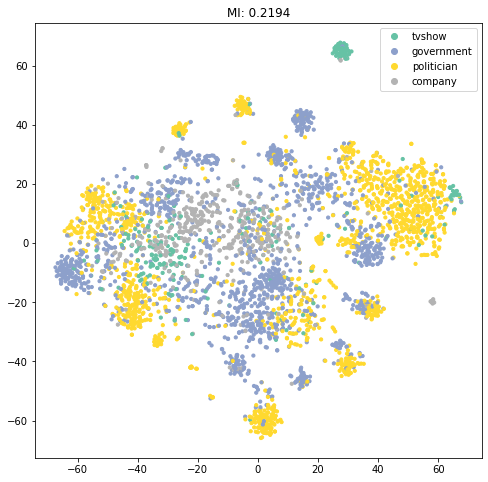

In [23]:
decomposition = TSNE(n_components=2)
xy_emb = decomposition.fit_transform(emb)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(xy_emb[:, 0], xy_emb[:, 1], c=labels, s=10, cmap=plt.cm.Set2)

plt.legend(handles=scatter.legend_elements()[0], labels=unique)
plt.title(f'MI: {mi:.4f}');

### Task 3. Hierarchical softmax (4 points)

Hierarchical softmax is an alternative way to approximate softmax in DeepWalk and similar models such as Walklets, Node2Vec. Remind the regular loss function with softmax:

$$\mathcal L = - \frac{1}{|V|\times N} \sum_{i=1}^{|V|\times N} \sum_{j=1}^L \log P(j|i) = - \frac{1}{|V|\times N} \sum_{i=1}^{|V|\times N} \sum_{j=1}^L \log \frac{\exp(v_i^\top u_j)}{\sum_{k=1}^{|V|}\exp(v_i^\top u_k)}$$

We have observed that computing $\sum_{k=1}^{|V|}\exp(v_i^\top u_k)$ is expensive in a large network. Indeed, it takes $O(|V|)$ since we need to compute $v_i^\top u_k$ for each $k$. 

Hierarchical softmax allows to approximate softmax by propagation probabilities in a binary tree where leaves are nodes in the original network. Consider a simple network on 6 nodes and the corresponding binary tree.

<img src="https://raw.githubusercontent.com/netspractice/network-science/main/images/hs_btree.png" width=600>

We observe that leaves correspond to nodes in the network: the leaf 5 corresponds to the node 0, the leaf 6 corresponds to the node 1 and so on. Let us call all other white nodes in the binary tree units.

Write a function `get_binary_tree` that takes number of leaves and returns a binary tree.

_Hint: create a binary tree by `nx.balanced_tree(2, depth, nx.DiGraph)` and drop extra leaves. The depth of the tree can be calculated as $\lceil \log_2 |V| \rceil$._

In [24]:
def get_binary_tree(n_leaves):
    depth = int(np.ceil(np.log2(n_leaves)))
    G = nx.balanced_tree(2, depth, nx.DiGraph)
    actualNLeaves = 2**depth
    last = 2**(depth + 1) - 2
    while actualNLeaves > n_leaves:
        G.remove_node(last)
        G.remove_node(last - 1)
        actualNLeaves -= 1
        last -= 2
    return G

In [25]:
btree = get_binary_tree(n_leaves=len(G))
leaves = [n for n in btree.nodes if btree.degree[n] == 1]
assert len(leaves) == len(G)
assert list(btree.nodes)[0] == 0
assert nx.is_weakly_connected(btree)
assert btree.in_degree[0] == 0
assert np.all([btree.in_degree[n] == 1 for n in range(1, len(btree))])
assert np.all([btree.out_degree[n] == 2 for n in range(len(btree) - len(leaves))])
assert np.all([btree.out_degree[n] == 0 for n in range(len(btree) - len(leaves), len(btree))])

If we assign a probability conditioned by the start node for each unit, we can calculate a probability of each context node as the product of probabilities of all units in the path from the root unit to a corresponding leaf taking $p_i$ if we go to the left and $1 - p_i$ if we go to the right from the unit $i$. For example, consider a path from the root unit to the context node 5 (leaf 10):

<img src="https://raw.githubusercontent.com/netspractice/network-science/main/images/hs_btree_proba.png" width=600>

$$P(5|i) = p_0\cdot (1-p_1) \cdot (1-p_4)$$

We can observe following thigs:
* Each unit divides probability space into two subspace, so that probabilities on leaves are summed up to 1.
* We make only 3 multiplucations instead of 6 summations in regular softmax. Indeed, the number of multiplications is equal to the depth of the binary tree $O(\log_2|V|)$. The number of summations in regular softmax is $O(|V|)$. That is, the cost of calculating probabilities for all context nodes is reduced from $O(|V|^2)$ to $O(|V|\log_2|V|)$.

We condition probabilities by the start node as follows:

$$p_j(i) = \sigma(v_i^\top u_j)$$

where $v_i$ is embedding of the start node $i$ and $u_j$ is embedding of the unit $j$. Thus, we have no embeddings for context nodes in this model. Note that $1-\sigma(v_i^\top u_j)$ can be substituted to $\sigma(-v_i^\top u_j)$. Let us call a sign under the sigmoid a turn $t_k$: $-1$ if we go to the left and $1$ if we go to the right. Thus the probability of co-occurance of the context node 5 and the start node, say, 1 is

$$P(5|1) = \sigma(t_0 v_1^\top u_0) \cdot \sigma(t_1 v_1^\top u_1) \cdot \sigma(t_2 v_1^\top u_4)$$

where $t_0=1$, $t_1=-1$, $t_2=-1$. Our objective is to maximize the probability of co-occurance of start nodes and context nodes by minimizing the negative log-likelihood, thus the loss function is turned out to

$$\mathcal L = - \frac{1}{|V|\times N} \sum_{i=1}^{|V|\times N} \sum_{j=1}^L \sum_{k=1}^K\log \sigma(t_{[jk]} v_i^\top u_{[jk]})$$

where $K$ is the path length from the root to the leaf excluding the leaf. Subscript $[jk]$ means the index corresponded to k-th step of the path to j-th context node. Note that the path length depends on a leaf, it makes calculating loss in mini-batch training inconvenient, so let us set $K$ as the depth of the tree and multiply the loss by _training mask_ $z_{jk}$: $0$ for all $k$ that greater than path length and $1$ otherwise. The final loss function is

$$\mathcal L = - \frac{1}{|V|\times N} \sum_{i=1}^{|V|\times N} \sum_{j=1}^L \sum_{k=1}^K\log \sigma(t_{[jk]} v_i^\top u_{[jk]}) z_{[jk]}$$

Let us create a dataset for computing a such loss function. Write a class `NodePathDataset`. 

Function `__init__` takes random walks, binary tree, depth of the binary tree and finds paths for each leaf.

Function `__len__` returns the number of random walks.

Function `__getitem__` takes an index of random walk and returns a tuple:

* start node, torch.int64
* context nodes, torch.tensor of the shape (number of context nodes)
* paths to the context nodes excluding a leaf: torch.tensor of the shape (number of context nodes, depth). Padded with zeros if the depth is greater than the path length.
* turns on the paths: torch.tensor of the shape (number of context nodes, depth). Padded with zeros if the depth is greater than the path length. Define the left turn as a link to the even unit.
* training mask on the paths: torch.tensor of the shape (number of context nodes, depth)

_Hint: use `nx.shortest_path(btree, 0, n)` to find a path from the root unit to the leaf `n` in the tree._

In [26]:
class NodePathDataset(Dataset):
    def __init__(self, rwalks, btree, depth):
        self.start_nodes = torch.tensor(rwalks[:, 0])
        self.context = torch.tensor(rwalks[:, 1:])
        self.paths = []
        self.turns = []
        self.masks = []

        leaves = [g for g in btree.nodes if btree.degree[g] == 1]
        for i in range(len(G)):
            shortest_path = nx.shortest_path(btree, 0, leaves[i])
            turns = []
            for i in range(len(shortest_path) - 1):
                if shortest_path[i + 1] % 2 == 0:
                    turns.append(1)
                else:
                    turns.append(-1)
            shortest_path = shortest_path[:-1]  
            mask = [1] * len(shortest_path)
            if len(shortest_path) < depth:
                n_extra = depth - len(shortest_path)
                shortest_path = shortest_path + [0] * n_extra
                mask = mask + [0] * n_extra
                turns = turns + [0] * n_extra
            self.paths.append(shortest_path)
            self.turns.append(turns) 
            self.masks.append(mask)

        self.paths = torch.tensor(self.paths)
        self.turns = torch.tensor(self.turns)
        self.masks = torch.tensor(self.masks)

    def __len__(self):
        return len(self.start_nodes)

    def __getitem__(self, idx):
        return (
            self.start_nodes[idx], 
            self.context[idx], 
            self.paths[self.context[idx]], 
            self.turns[self.context[idx]], 
            self.masks[self.context[idx]]
        )

In [27]:
depth = 12
dataset = NodePathDataset(rwalks, btree, depth)
start_node, context, paths, turns, masks = dataset[0]
assert start_node.shape == ()
assert context.shape == (4,)
assert paths.shape == turns.shape == masks.shape == (4, 12)
assert start_node == 0
leaves = [n for n in btree.nodes if btree.degree[n] == 1]
shortest_path = nx.shortest_path(btree, 0, leaves[context[1]])[:-1]
mask = [1] * len(shortest_path)
if len(shortest_path) < depth:
    n_extra_units = depth - len(shortest_path)
    shortest_path = shortest_path + [0] * n_extra_units
    mask = mask + [0] * n_extra_units
assert np.all(shortest_path == paths[1].numpy())
assert np.all(mask == masks[1].numpy())

In [28]:
dloader = DataLoader(dataset, batch_size=2)
for start_nodes, context, paths, turns, masks in dloader:
    break
start_nodes.shape, context.shape, paths.shape, turns.shape, masks.shape

(torch.Size([2]),
 torch.Size([2, 4]),
 torch.Size([2, 4, 12]),
 torch.Size([2, 4, 12]),
 torch.Size([2, 4, 12]))

Write a function `hierarchical_softmax_loss` that takes vectors $v$, $u$ and returns the hierarchical softmax loss before reduction $\frac{1}{|V|\times N} \sum_{i=1}^{|V|\times N} \sum_{j=1}^L$.

_Remark: to prevent $-\infty$ in log, add $\varepsilon=1^{-6}$ as follows `torch.log(x + 1e-6)`_

In [29]:
def hierarchical_softmax_loss(v, u, turns, masks):
    loss = torch.empty(turns.shape[0], turns.shape[1])
    for i in range (turns.shape[0]):
        for j in range(turns.shape[1]):
            loss[i][j] = torch.sum(-torch.log(torch.sigmoid(torch.tensor([v[i] @ u[i, j, k] * turns[i, j, k] for k in range(turns.shape[2])])) + 1e-6) * masks[i, j])
    return loss.requires_grad_()

In [30]:
np.random.seed(0)
start_node_emb = torch.randn(len(G), 16)
path_emb = torch.randn(len(G) - 1, 16)
v = start_node_emb[start_nodes]
u = path_emb[paths]
loss = hierarchical_softmax_loss(v, u, turns, masks)
assert loss.shape == (2, 4)
l = -torch.log(torch.sigmoid(torch.tensor([v[0] @ u[0, 0, i] * turns[0, 0, i] for i in range(12)])) + 1e-6) * masks[0, 0]
assert round(l.sum().item(), 2) == round(loss[0, 0].item(), 2)


Here is SkipGram model with hierarchical softmax. The number of vectors in `path_emb` is `n_nodes - 1`, since it can be shown that the number of units is equal to $|V|-1$.

In [31]:
class SkipGramHierarchicalSoftmax(nn.Module):
    def __init__(self, n_nodes, dim):
        super().__init__()
        self.start_node_emb = nn.Embedding(n_nodes, dim)
        self.path_emb = nn.Embedding(n_nodes - 1, dim)
    def forward(self, start_nodes, paths, turns, masks):
        v = self.start_node_emb(start_nodes)
        u = self.path_emb(paths)
        loss = hierarchical_softmax_loss(v, u, turns, masks)
        return loss

Train the model using Adam optimizer.

In [32]:
sgmodel = SkipGramHierarchicalSoftmax(n_nodes=len(G), dim=16)
epoch_loss = []
opt = Adam(sgmodel.parameters(), lr=0.1)
dloader = DataLoader(dataset, batch_size=len(G))
for epoch in trange(50):
    for start_nodes, context, paths, turns, masks in dloader:
        loss = sgmodel(start_nodes, paths, turns, masks).sum(dim=1).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
    epoch_loss.append(loss.item())
plt.plot(epoch_loss);

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

Evaluate the model by mutual information between ground truth labels and cluster indices.

In [ ]:
with torch.no_grad():
    emb = sgmodel.start_node_emb(torch.arange(len(G)))
_, pred_labels, _ = k_means(emb, n_clusters=8)
mi = mutual_info_score(labels, pred_labels)
assert mi > 0.15

Plot t-SNE visualization of node embeddings.

In [ ]:
decomposition = TSNE(n_components=2)
xy_emb = decomposition.fit_transform(emb)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(xy_emb[:, 0], xy_emb[:, 1], c=labels, s=10, cmap=plt.cm.Set2)
plt.legend(handles=scatter.legend_elements()[0], labels=unique)
plt.title(f'MI: {mi:.4f}');

The hierarchical softmax can be improved by building a binary tree where hubs are closer to the root unit. In this task we have used the randomly builded binary tree and we can see that it works pretty well with respect to negative sampling.

### Task 4. GraRep (3 points)

The idea behind GraRep is to account for multiscale relationships between nodes. For example,a student can have 1-hop neighborhood of friends, 2-hop neighborhood of classmates, 3-hop neighborhood of society and so on.

<img src="https://raw.githubusercontent.com/netspractice/network-science/main/images/multiscale_relationships.png" width=350>

Unlike DeepWalk, GraRep defines different objective functions for capturing the different $k$-step local relational information by manipulating transition matrices in the $k$-th powers defined over the graph. Recall that the transition matrix is $P = D^{-1}A$ where $D$ is a degree matrix. $P_{ij}$ refers to a probability to move from the node $i$ to the node $j$ in one step of a random walk. Therefore, $P^k_{ij}$ is a probability to move from the node $i$ to the node $j$ in $k$ steps of a random walk. 

Write a function `csr_transition_matrix` that takes a graph and returns a transition matrix. To save memory and speed up the following calculation of powers, convert transition matrix to sparse format by `scipy.sparse.csr_matrix`.

In [ ]:
import scipy
def csr_transition_matrix(G):
    i = range(len(G.nodes()))
    degs = [1/v for k,v in G.degree]
    D1 = csr_matrix((degs, (i, i)),
                            shape=(G.number_of_nodes(),
                            G.number_of_nodes()),
                            dtype=np.float32)
    A = csr_matrix(nx.adjacency_matrix(G, i)) 
    tr_matrix = csr_matrix(D1.dot(A))
    return tr_matrix

In [ ]:
P = csr_transition_matrix(G)
assert type(P) == csr_matrix
assert P.shape == (len(G), len(G))
assert round(P[3, 9], 4) == 0.0417

Similar to DeepWalk, there are two types of embeddings:
* $v_i$ is a vector that represents the start node $i$
* $u_j$ is a vector that represents the context node $j$

Our objective aims to maximize: 1) the probability that these pairs come from the graph, and 2) the probability that all other pairs do not come from the graph (negative samples). The objective function for nodes $i, j$ in the transition matrix of the power $k$ is

$$\mathcal L^k_{ij} = P^k_{ij}\log \sigma(v_i^\top u_j) + \frac{\lambda}{|V|}\sum_{t=1}^{|V|}P^k_{tj}\log \sigma(-v_t^\top u_j)$$

where $\lambda$ is the hyperparameter indicating the number of negative samples. Optimizing this objective makes observed pairs $(i, j)$ have similar embeddings, while scattering unobserved pairs $(t, j)$. Substitution $v_i^\top u_j = X_{ij}$ and setting $\frac{\partial \mathcal L_{ij}}{ \partial X_{ij}} = 0$ yields

$$v_i^\top u_j = X_{ij}^k = \log \frac{P^k_{ij}}{\sum_{t=1}^{|V|}P^k_{tj}} - \log\frac{\lambda}{|V|}$$

Let us call $X^k$ log probabilistic matrix. Write a function `log_probabilistic_matrix` that takes a transition matrix, hyperparameter $\lambda$ and returns a log probabilistic matrix.

_Remark: to prevent $-\infty$ in log, add $\varepsilon=1^{-6}$ as follows `np.log(x + 1e-6)`_

In [ ]:
def log_probabilistic_matrix(P, lambd):
    c_sum = P.sum(axis=0)
    const = np.full(P.shape, lambd / P.shape[0])
    P = P / c_sum
    X = np.log(P + 1e-6) - np.log(const + 1e-6)
    return X

In [ ]:
X = log_probabilistic_matrix(P, lambd=5)
assert type(X) == np.matrix
assert X.shape == (len(G), len(G))
assert round(X[3, 9], 4) == 3.182

The log probabilistic matrix $X^k$ can be approximated by truncated SVD so that

$$X^k \approx X_d^k = U_d^k \Sigma_d^k (V_d^k)^\top$$

where $d$ is the number of singular values of truncated SVD. Thus, embeddings of start nodes can be obtained by 

$$v_i = \left[U_d^k \sqrt{\Sigma_d^k}\right]_i$$ 

and embeddings of context nodes by 

$$u_j = \left[\sqrt{\Sigma_d^k} (V_d^k)^\top\right]_j$$ 

_Remark: the power 1/2 makes SVD symmetric. It is empirically shown that the symmetric SVD is better for social graphs and makes embeddings more "similar" to corresponding embeddings of SkipGram with negative sampling in a sence of some matrix properties._

Write a function `svd_emb` that takes a log probabilistic matrix, number of dimensions (number of largest singular values) in truncated SVD and returns embeddings of start nodes.

_Hint: use `scipy.sparse.linalg.svds` to calculate truncated SVD for a given number of singular values._

In [ ]:
def svd_emb(X, dim):
    u, s, vh = svds(X, dim)
    truncated_SVD = u @ np.diag(np.sqrt(s))
    return truncated_SVD

In [ ]:
_emb = svd_emb(X, dim=4)
assert type(_emb) == np.ndarray
assert _emb.shape == (3873, 4)


The resulting node embeddings are concatenated from the log probabilistic matrices $X, X^2, ..., X^k$.

In `grarep_emb`, we calculate powers of transition matrix $P, P^2, \dots, P^k$, calculate and concatenate embeddings of start nodes, then we compress them to the original number of dimensions by PCA.

In [ ]:
def grarep_emb(G, dim, k, lambd):
    emb = []
    P_1 = csr_transition_matrix(G)
    P = P_1.copy()
    for i in trange(k):
        X = log_probabilistic_matrix(P, lambd=lambd)
        _emb = svd_emb(X, dim=dim)
        emb.append(_emb)
        if i == (k - 1):
            continue
        P = P @ P_1
    emb = PCA(n_components=dim).fit_transform(np.concatenate(emb, axis=1))
    return emb

Finally, we evaluate the model by mutual information between ground truth labels and cluster indices.

In [ ]:
emb = grarep_emb(G, dim=16, k=4, lambd=5)
assert emb.shape == (len(G), 16)
_, pred_labels, _ = k_means(emb, n_clusters=8)
mi = mutual_info_score(labels, pred_labels)
assert mi > 0.22

Plot t-SNE visualization of node embeddings.

In [ ]:
decomposition = TSNE(n_components=2)
xy_emb = decomposition.fit_transform(emb)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(xy_emb[:, 0], xy_emb[:, 1], c=labels, s=10, cmap=plt.cm.Set2)
plt.legend(handles=scatter.legend_elements()[0], labels=unique)
plt.title(f'MI: {mi:.4f}');